# Predição do Desfecho do Paciente (Óbito, Cura ou Não Definido) by Iasmin Marques

* Variáveis de entrada: idade, sexo, presença de comorbidades (diabetes, hipertensão, cardiopatia, obesidade, imunodepressão, etc.), uso de ventilação mecânica, internação em UTI, vacinação contra COVID-19 e gripe.

* Técnicas sugeridas: Regressão Logística, Random Forest, XGBoost.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Carregar os dados do OpenDataSUS (ajuste o caminho caso já tenha baixado)
df = pd.read_csv("/content/drive/MyDrive/TCC I/Analise de Dados/INFLUD24-03-02-2025.csv", sep=";", encoding="latin1", low_memory=False)
df

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,VG_REINF,REINF,FAB_ADIC,LOT_RE_BI,FAB_RE_BI,DOSE_ADIC,DOS_RE_BI,LOTE_ADIC,TABAG,CASO_SRAG
0,04/01/2024,1,04/01/2024,1,CE,1 CRES FORTALEZA,1519.0,FORTALEZA,230440,SOPAI HOSPITAL INFANTIL,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,15/01/2024,3,31/12/2023,1,BA,NUCLEO REGIONAL DE SAUDE LESTE,1380.0,SALVADOR,292740,CARDIO PULMONAR DA BAHIA,...,NaN,2,NaN,GF9673,103 - COVID-19 PFIZER - COMIRNATY BIVALENTE,NaN,03/03/2023,NaN,NaN,1.0
2,15/01/2024,3,10/01/2024,2,PB,I NRS JOAO PESSOA,1377.0,JOAO PESSOA,250750,HOSPITAL DE EMERGENCIA E TRAUMA SENADOR HUMBER...,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,11/01/2024,2,04/01/2024,1,GO,SUDOESTE II,1800.0,JATAI,521190,HOSPITAL PADRE TIAGO NA PROVIDENCIA DE DEUS,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,16/01/2024,3,14/01/2024,3,BA,NUCLEO REGIONAL DE SAUDE LESTE,1380.0,SALVADOR,292740,PA MARIA DA CONCEICAO SANTIAGO IMBASSAY,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266425,27/11/2024,48,23/11/2024,47,MG,BELO HORIZONTE,1449.0,BELO HORIZONTE,310620,HOSPITAL INFANTIL JOAO PAULO II,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
266426,06/12/2024,49,04/12/2024,49,MG,GOVERNADOR VALADARES,1471.0,GOVERNADOR VALADARES,312770,HOSPITAL MUNICIPAL,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
266427,16/12/2024,51,13/12/2024,50,SP,GVE XXXI SOROCABA,1353.0,ITU,352390,VIGILANCIA EPIDEMIOLOGICA,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
266428,05/12/2024,49,04/12/2024,49,DF,NaN,NaN,BRASILIA,530010,HOSPITAL AGUAS CLARAS,...,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
# Selecionar as colunas de interesse
cols = ["NU_IDADE_N", "CS_SEXO", "FEBRE", "TOSSE", "DISPNEIA", "SATURACAO", "DIABETES",
        "CARDIOPATI", "OBESIDADE", "IMUNODEPRE", "UTI", "SUPORT_VEN", "VACINA_COV", "EVOLUCAO"]
df = df[cols]

In [ ]:
# Remover valores nulos
df = df.dropna()

In [ ]:
df["CS_SEXO"] = df["CS_SEXO"].map({"M": 0, "F": 1})# Converter colunas categóricas em numéricas

In [ ]:
# Ou, se quiser incluir "Óbito por outras causas" como óbito:
df["EVOLUCAO"] = df["EVOLUCAO"].replace({3: 2, 9: np.nan})  # 3 vira 2 (óbito), 9 vira NaN

In [ ]:
df["EVOLUCAO"] = df["EVOLUCAO"].replace({1: "Cura", 2: "Óbito"})

In [ ]:
print(df["EVOLUCAO"].value_counts())

EVOLUCAO
Cura     50491
Óbito    12873
Name: count, dtype: int64


In [ ]:
min_class_size = df["EVOLUCAO"].value_counts().min()

if pd.isna(min_class_size) or min_class_size == 0:
    print("⚠️ Ainda há um problema com EVOLUCAO. Verifique os dados!")
else:
    min_class_size = int(min_class_size)  # Garantir que seja inteiro
    df_balanced = df.groupby("EVOLUCAO").sample(n=min_class_size, random_state=42)
    print("✅ Balanceamento concluído!")


✅ Balanceamento concluído!


In [ ]:
    # Separar variáveis de entrada (X) e saída (y)
    X = df_balanced.drop(columns=["EVOLUCAO"])
    y = df_balanced["EVOLUCAO"]

    # Padronizar os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Codificar a variável alvo
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    # Dividir em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

    # Modelos de Machine Learning
    models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")
    }

In [ ]:
    # Treinar e avaliar
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(f"\n🔹 Modelo: {name}")
        print("Acurácia:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names=encoder.classes_))




🔹 Modelo: Random Forest
Acurácia: 0.7203883495145631
              precision    recall  f1-score   support

        Cura       0.72      0.72      0.72      2590
       Óbito       0.72      0.72      0.72      2560

    accuracy                           0.72      5150
   macro avg       0.72      0.72      0.72      5150
weighted avg       0.72      0.72      0.72      5150



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:40:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 Modelo: XGBoost
Acurácia: 0.7522330097087379
              precision    recall  f1-score   support

        Cura       0.76      0.74      0.75      2590
       Óbito       0.74      0.77      0.75      2560

    accuracy                           0.75      5150
   macro avg       0.75      0.75      0.75      5150
weighted avg       0.75      0.75      0.75      5150



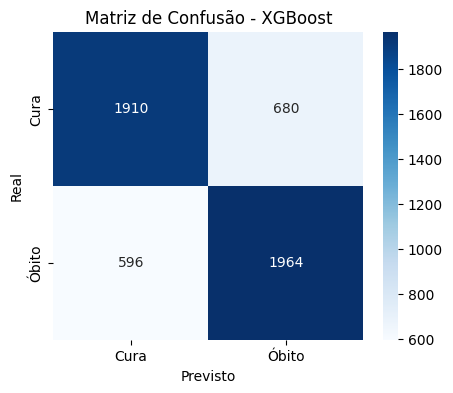

In [ ]:
        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
        plt.xlabel("Previsto")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusão - {name}")
        plt.show()

# Resultados /  Interpretação

## XGBoost teve um desempenho melhor do que Random Forest

XGBoost obteve 75.2% de acurácia, enquanto o Random Forest teve 72.0%.
A diferença não é muito grande, mas indica que XGBoost é mais eficiente para este problema.

## Recall e Precisão são equilibrados
Ambos os modelos apresentam uma boa distribuição entre Cura e Óbito.
O XGBoost tem um recall maior para Óbito (77%), o que significa que ele consegue detectar melhor pacientes com maior risco.
Para Cura, a precisão do XGBoost (76%) também foi melhor que a do Random Forest (72%).

## O modelo ainda pode melhorar
75% de acurácia é um bom resultado, mas pode ser otimizado.
Podemos testar ajustes de hiperparâmetros para XGBoost e adicionar mais features relevantes.

## Próximos passos
- Testar hiperparâmetros no XGBoost para aumentar a performance.
- Explorar mais variáveis (exemplo: tempo de internação, uso de ventilação mecânica, exames laboratoriais).
- Criar visualizações para entender melhor os padrões dos pacientes.
